# Aims of molecular simulation

 * *Numerical microscope* : perform "computer" experiments to **validate** physical theories
 * *Accessing properties* : compute **quantitative** macroscopic or thermodynamic properties with the use of **molecular simulations**. Go beyond the lab/costs barriers.

## Example : Computing macroscopic properties

* $N$ particles, typically atoms, between $10^3$ to $10^9$
* $q=(q_1,\dots,q_N)\in\mathcal{D}$ position of atoms
* $\mathcal{D}$ is the *configuration space*: $\mathcal{D}=\mathbb{R}^{3N}$ or $(L\mathbb{T})^{3N}$ (torus of length $L$)
* Momentum variable $p=(p_1,\dots,p_N)\in\mathbb{R}^{3N}$. $(q,p)$ is the *microscopic state* or the *configuration* of the system, belong to $\mathcal{E}$ which is the *phase space*

In the framework of statistical physics, macroscopic quantities are written as averages over thermodynamics ensembles, which are probability measures on all the admissible configurations:
$$
\boxed{
    \mathbb{E}_\mu(\varphi)=\int_{\mathcal{E}}\varphi(q,p)\,\mu(dq\,dp)
}
$$
$\varphi$ is the observable (bounded measurable function).
For example, if one is interested in computing the bulk pressure $P$ inside a Lennard-Jones liquid of particles of mass $m_i$, then $P=\mathbb{E}_\mu(\varphi)$ with
$$
\begin{aligned}
\varphi(q,p)&=\dfrac{1}{3\left\lvert\mathcal{D}\right\rvert}\sum_{i=1}^N\left(\dfrac{\left\lvert p_i\right\rvert^2}{m_i}-q_i\cdot\dfrac{\partial V}{\partial q_i}(q)\right)\\
V(q)&=\sum_{1\leqslant i<j\leqslant N}\mathcal{V}\left(\left\lvert q_i-q_j\right\rvert\right)\\
\mathcal{V}(r)&=4\varepsilon\left(\left(\dfrac{\sigma}{r}\right)^{12}-\left(\dfrac{\sigma}{r}\right)^6\right)\\
\end{aligned}
$$
with $\varepsilon=1.66\times 10^{-21}\,\mathrm{J}$ and $\sigma=3.405\times 10^{-10}\,\mathrm{m}$ for Argon for instance.

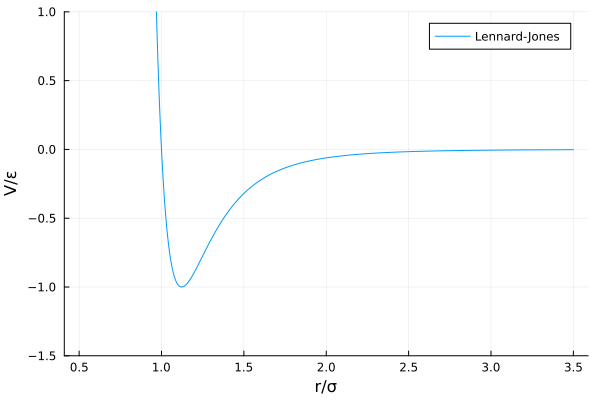

In [2]:
using Plots

function V(r)
    return 4*(r^(-12)-r^(-6))
end

X = LinRange(0.5,3.5,2000)
plot(
    X,V.(X),label="Lennard-Jones"
)
ylims!((-1.5,1))
xlabel!("r/σ")
ylabel!("V/ε")

2 questions: 
* what is $\mu$ ?
* how can one compute the multi-dimensional integral ?

Some answers:
* $\mu$ depend on the thermodynamic ensemble at hand. For our purpose, we will work with the *canonical ensemble* which describe systems in contact with some energy thermostat. Usually, it is called *NVT ensemble*, since the number of particles $N$, the volume $V$ and the temperature $T$ are fixed. In that case, the probability measure $\mu$ on $\mathcal{E}$ reads
$$
\mu(dq\,dp)=Z_\mu^{-1}\exp\left(-\beta H(q,p)\right)\,dq\,dp,
$$
where $\beta=1/(k_B T)$ is the *inverse temperature* ($T$ denotes the temperature and $k_B$ is the Boltzmann constant), and $H$ is the Hamiltonian of the system. The normalization constant 
$$
Z_\mu=\int_\mathcal{E}\exp\left(-\beta H(q,p)\right)\,dq\,dp
$$
is called the partition function. The Hamiltonian of the system is usually of the form
$$
H(q,p)=V(q)+\dfrac{p^\mathsf{T}M^{-1}p}{2},
$$
where $M$ is the mass tensor, that is $M=\mathrm{diag}(m_1,m_1,m_1,\dots,m_N,m_N,m_N)$ and $V$ is the potential function (for instance the Lennard-Jones potential above).

Under $\mu$, the position $q$ and the momentum $p$ are independent random variables. Therefore, sampling configurations $(q,p)$ according to the canonical measure $\mu(dq\,dp)$ can be performed by independently sampling positions according to $\nu(dq)$ and momenta according to $\kappa(dp)$ where
$$
\nu(dq)=Z_\nu^{-1}\mathrm{e}^{-\beta V(q)}\,dq,\quad Z_\nu=\int_{\mathcal{D}}\mathrm{e}^{-\beta V(q)}\,dq,\quad \kappa(dp)=\left(\dfrac{\beta}{2\pi}\right)^{3N/2}\prod_{i=1}^{N}m_i^{-3/2}\exp\left(-\dfrac{\beta}{2}p^\mathsf{T}M^{-1}p\right)\,dp
$$
Hence the real issue is to sample from $\nu$.

* We cannot use standard quadrature methods. The only realistic option is to rely on *ergodic averages*, where configurations $(q^k,p^k)$ are generated according to the probability measure $\mu$ by integrating a time-discrete dynamics. Then the integral is approximated by
$$
\lim\limits_{K\to+\infty}\dfrac{1}{K}\sum_{k=1}^{K}\varphi(q^k,p^k)
$$
Here comes the use of Markov Chain Monte Carlo methods !

## Markov Chain Monte Carlo methods

We consider a time-homogeneous Markov chain $(q^k)_k$, a sequence of random variables sampled from a *probability transition kernel* $P(q,dq')$, that is $q^{k+1}$ is sampled only knowing $q^k$ according to $P(q^k,dq')$. The transition kernel is characterized by the fact that, for any state $q$ and for any observable $\varphi$,
$$
(P\varphi)(q)=\int_\mathcal{D}\varphi(q')P(q,dq')
$$

Some properties are needed so that ergodic theorems can hold:
* *Stationarity*: a probability distribution $\pi$ is an *invariant* measure for $P$ is 
$$
\int_\mathcal{D}P(q,dq')\pi(dq)=\pi(dq')
$$
* *Aperiodic irreducibility*: for any Borel subset $S\subset\mathcal{D}$ such that $\left\lvert S\right\rvert>0$, for $\pi$-almost all initial conditions $q^0$, there exists $n_0>0$ such that for any $n\geqslant n_0$,
$$
P^n(q^0,S)>0
$$
This means that the set $S$ can be reached in $n$ steps with positive probability starting from $q^0$.
* *Reversibility*: $P$ is reversible w.r.t. $\pi$ if (*detailed balance condition*)
$$
P(q,dq')\pi(dq)=P(q',dq)\pi(dq')
$$
Note that it implies that $\varphi$ is an invariant measure for $P$.

The following theorem shows that multi-dimensional integrals can be computed via ergodic averages.

**Proposition.** Let $(q^k)_{k\geqslant 0}$ be a Markov chain in $\mathcal{D}$ with invariant probability measure $\pi$. If $(q^k)_{k\geqslant 0}$ is aperiodically irreducible, then it is *pathwise ergodic*, meaning that for any observable $\varphi$ and $\pi$-almost all initial conditions $q^0$,
$$
\lim\limits_{K\to+\infty}\dfrac{1}{K}\sum_{k=1}^{K}\varphi(q^k)=\int_{\mathcal{D}}\varphi(q)\pi(dq)\quad\mathrm{a.s.}
$$

Let us list highlight ways to create Markov chains that have $\nu=Z_\nu^{-1}\mathrm{e}^{-\beta V}$ as their invariant probability measure.

## The Metropolis-Hastings algorithm

Introduce the Metropolis--Hastings ratio
$$
r(q,q')=\dfrac{P(q',dq)\nu(dq')}{P(q,dq')\nu(dq)}
$$
and
$$
R(q,q')=\min\left(1,r(q,q')\right)
$$
Let $q^0\in\mathcal{D}$ and construct the following Markov chain
$$
q^{k+1}=q^k+\mathbf{1}_{U^k\leqslant R(q^k,\tilde{q}^{k+1})}\left(\tilde{q}^{k+1}-q^k\right)
$$
where $\tilde{q}^{k+1}$ is sampled according to $P(q^k,\cdot)$ and $U^k$ is a random variable following a uniform law on $(0,1)$. Then $(q^k)_{k\geqslant 0}$ admits $\nu$ as its invariant probability distribution.

**Question.** What is the signification of $R(q,q')$ for symmetric proposition kernels (*i.e.* P(q,dq')=P(q',dq)) ?

### Examples of proposition transition kernels

We denote by $n=dN$ with $d$ the dimension ($d=3$ in our world, but numerical examples will be one-dimensional).

#### Random walks

Let 
$$
P(q,dq') = (\sigma\sqrt{2\pi})^{-n}\exp\left(-\dfrac{\left\lvert q'-q\right\rvert^2}{2\sigma^2}\right)\,dq'
$$
**Question.** What is the underlying proposal dynamics, that is what is the dynamics to go from $q^k$ to $\tilde{q}^{k+1}$ in the M-H algorithm ?

**Question.** Identify what is $\sigma$ in the following code.

In [3]:
using Cubature

In [4]:
# Metropolis-Hastings algorithm
function RWMH(V, β, Δt=0.01, Nsteps=10^5, q0=rand())
    Nsteps = Int(Nsteps)
    trajectory = Vector{Float64}(undef, Nsteps)
    trajectory[1] = q0
    q = q0
    for k in 2:Nsteps
        proposal = q+sqrt(2*Δt/β)*randn()
        log_ratio = -β*(V(proposal)-V(q))
        if log(rand()) <= log_ratio
            q = proposal
        end
        trajectory[k] = q
    end
    return trajectory
end;

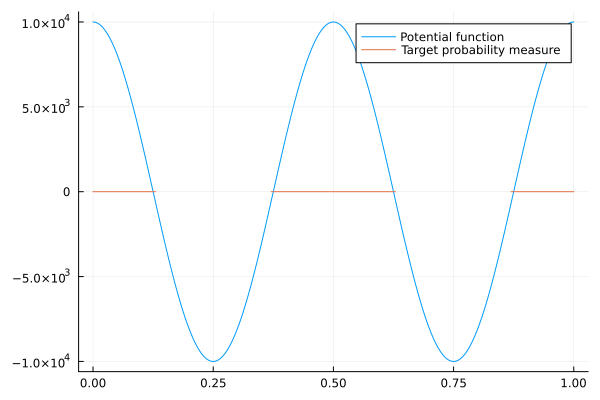

In [12]:
# Plot the potential energy function and the target probability measure ν 

β = 1.
Z = 0.
function V_cos_2(x)
    return 10000*cos(4*π*x)
end

function mu(x, V, β)
    return exp(-β*V(x))
end

function set_Z(V, β)
    global Z = hquadrature(x -> mu(x, V, β), 0,1)[1]
end

set_Z(V_cos_2, β)
function pi_invariant(x, V, β)
    return mu(x, V,β) / Z
end


XX = LinRange(0,1,500)
plot(XX, V_cos_2.(XX), label="Potential function")
plot!(XX, pi_invariant.(XX, V_cos_2, β), label="Target probability measure")

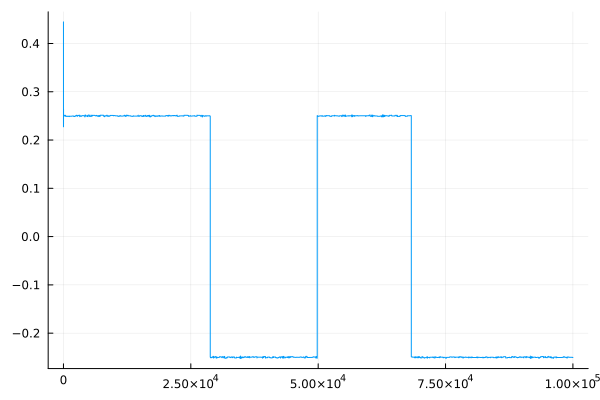

In [13]:
# Plot "unperiodized" RWMH trajectory

RWMH_trajectory = RWMH(V_cos_2,β)
plot(
    1:length(RWMH_trajectory),
    RWMH_trajectory,
    label=""
)

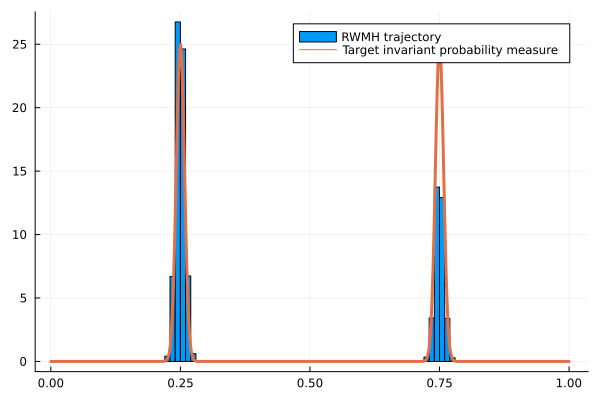

In [7]:
# Plot sampling results

histogram(
    mod.(RWMH_trajectory,1),
    label="RWMH trajectory",
    normalize=:pdf,
    bins=80
)
plot!(
    XX,
    pi_invariant.(XX, V_cos_2, β),
    label="Target invariant probability measure",
    linewidth=3
)

**Question.** Try removing the Metropolis-Hastings acceptance/rejection procedure. What do you see ?

**Question.** Try changing independently $T$, $\Delta t$, and $N_{steps}$. What do you see on the trajectory and on the sampling results ? How do you interpret such results ?

**Question.** Now choose the following double-well potential (defined on $\mathbb{T}$) $V(x) = 100\cos(4\pi x)$. What do you see on the trajectory ? Modify the amplitude in front of the cosine, and see how everything changes. Try setting a lower/higher temperature.

**Question.** Plot the rejection rate probability (estimated by the number of times you rejected a proposal divided by the total number of iterations) as a function of the time step $\Delta t$ (you may simply adapt the existing code to also output the estimated rejection rate probability). How does it scale (try a log-log plot) ?

**Question. (Can be skipped)** Go back to the first potential function. Now change the proposal dynamics to
$$
q'=q+\sigma U,\qquad U\sim\mathcal{U}((-1,1)^n)
$$
What is the corresponding transition kernel ? Code a RWMH_uniform() function that codes this version of the RWMH algorithm.

## The MALA algorithm

The previous example with a double-well potential shows that it is very difficult in real life to sample the whole configurational space as there exists a lot of local minimas (metastable configurations) separated by high energy barriers that are very unlikely to be crossed (see the expression of the Metropolis--Hastings ratio when the transition kernels are symmetric). Moreover, the dynamics can stay stuck a lot more if it is not allowed to move, which highlight the following: we want to propose larger moves (with a larger time step) as we know the dynamics can be stuck, bu the rejection rates prevent the dynamics from moving in that case.

An improved algorithm is the Metropolis Adjusted Langevin Algorithm (MALA) which takes into account the *geometry* of the potential function inside its proposition kernel. In fact, the proposal dynamics is an Euler-Maruyama discretization of the overdamped Langevin dynamics, which reads
$$
dq_t = -\nabla V(q_t)\,dt + \sqrt{2\beta^{-1}}\, dW_t
$$
so that its Euler-Maruyama discretization writes
$$
q' = q - \nabla V(q)\Delta t + \sqrt{2\Delta t\beta^{-1}}\,G,\qquad G\sim\mathcal{N}(0,\mathrm{I}_n)
$$

**Question.** Adapting from the previous RWMH code, write a ```MALA()``` function that perform an unbiased sampling of the probability distribution $\nu$. You will need to compute $\nabla V$. Also, note that the proposition kernel is not symmetric anymore !

**Question.** How does the rejection rate probabilities scale as a function of the time step ?

In [8]:
## MALA algorithm

## The Hamiltonian Monte Carlo algorithm

This method aims at sampling $\mu$ so that $\nu$ can be recovered as its marginal in position. The idea is to use the Hamiltonian dynamics as the proposal kernel, as it already contains the physics information of the potential function.

The Hamiltonian dynamics writes
$$
\left\lbrace
\begin{aligned}
dq_t & = \nabla_p H(q_t,p_t)\,dt,\\
dp_t & = -\nabla_q H(q_t,p_t)\,dt
\end{aligned}
\right.
\qquad
J=\begin{pmatrix} 
0_n & \mathrm{I}_n\\-\mathrm{I}_n & 0_n
\end{pmatrix}
$$

**Question.** For a Hamiltonian function being separable and of the form $H(q,p)=V(q)+\dfrac{p^\mathsf{T}M^{-1}p}{2}$, write the Hamiltonian dynamics.

In order for the HMC algorithm to perform an unbiased sampling, one needs to choose a *symplectic* and *time-reversible* numerical flow $\varphi_{\Delta t}$, that is
$$
J\left(\nabla\varphi_{\Delta t}\right)J=J,\qquad \varphi_{-\Delta t} = S\circ\varphi_{\Delta t}\circ S 
$$
A popular example is the *Störmer-Verlet* scheme which updates the configuration $(q^k,p^k)$ to $(q^{k+1},p^{k+1})$ by
$$
\left\lbrace
\begin{aligned}
    p^{k+1/2}&= p^k - \dfrac{\Delta t}{2}\nabla_q H(q^k,p^{k+1/2}),\\
    q^{k+1}&= q^k + \Delta t\dfrac{\nabla_p H(q^k,p^{k+1/2})+\nabla_p H(q^{k+1},p^{k+1/2})}{2},\\
    p^{k+1}&= p^{k+1/2}-\dfrac{\Delta t}{2}\nabla_q H(q^{k+1},p^{k+1/2})
\end{aligned}
\right.
$$
The time-reversibility property crucially depend on the Hamiltonian function. A condition is that it is an even function of the momenta.

**Question.** Write the Störmer-Verlet scheme for a Hamiltonian function of the form $H(q,p)=V(q)+\dfrac{p^\mathsf{T}M^{-1}p}{2}$. Notice that the Hamiltonian being separable, it is much nicer than it looks !

The HMC algorithm to directly sample from $\nu$ now reads: let $q^0$ be the initial configuration. Iterate on $k\geqslant 0$:
1. Sample $p^k$ according to $Z_\mu^{-1}\mathrm{e}^{-\beta H(q^k,\cdot)}$, the conditional probability of $p$ given $q^k$; 
2. Apply one step of the Hamiltonian dynamics, the obtained configuration is denoted by $(\tilde{q}^{k+1},\tilde{p}^{k+1})$.
3. Draw a random variable $U^k$ with uniform law on $[0,1]$: 
   1. if $U^k\leqslant \exp\left(-\beta(H(\tilde{q}^{k+1},\tilde{p}^{k+1})+H(q^k,p^k))\right)$, accept the proposal and set $q^{k+1}=\tilde{q}^{k+1}$;
   2. else, reject the proposal and set $q^{k+1}=q^k$.


**Question.** Code the HMC algorithm with the Hamiltonian function being $H(q,p)=V(q)+\dfrac{p^\mathsf{T}p}{2}$ with $V$ being your favorite $1$-periodic potential function. 

**Question.** How does the rejection rate probabilities scale as a function of the time step ? Are you able to compare with previous results (there is a bit of a catch here) ?

In [9]:
## HMC algorithm

## The Generalized Hamiltonian Monte Carlo algorithm

The GHMC method is a popular variant of HMC which is based on the discretization of the Langevin dynamics:
$$
  \left\lbrace
  \begin{aligned}
    d q_t &= \nabla_{p}H(q_t,p_t)\,d t,\\
    d p_t &= -\nabla_{q}H(q_t,p_t)\,d t-\gamma\nabla_pH(q_t,p_t)\,d t+\sqrt{2\gamma\beta^{-1}}\,d W_t,
  \end{aligned}
  \right.
$$
where $\gamma>0$ is the friction parameter (which can be chosen to be a more general definite positive symmetric matrix), and $(W_t)_{t\geqslant 0}$ is a standard $n$-dimension Brownian motion. The method is obtained thanks to a splitting technique, considering separately the Hamiltonian dynamics and the Ornstein-Uhlenbeck dynamics on the momenta, which induces a partial refreshment of the momenta instead of a full resampling as in HMC. A Strang splitting based on these elements leads to the following algorithm:
Let $(q^0,p^0)$ be the starting configuration, iterate on $k\geqslant 0$:
1. Evolve the momenta by integrating the fluctuation-dissipation part of the Langevin dynamics with time increment $\Delta t/2$ and initial condition $(q^k,p^k)$. The configuration obtained from this step is denoted by $(q^k,p^{k+1/4})$.
2. Apply one step of the Hamiltonian dynamics. The proposal is denoted by $(\tilde{q}^{k+1},\tilde{p}^{k+3/4})$.
3. Draw a random variable $U^k$ with uniform law on $[0,1]$:
   1. if $U^k\leqslant \exp\left(-\beta(H(\tilde{q}^{k+1},\tilde{p}^{k+3/4})+H(q^k,p^{k+1/4}))\right)$, accept the proposal and set $(q^{k+1},p^{k+3/4})=(\tilde{q}^{k+1},\tilde{p}^{k+3/4})$;
   2. else, reject the proposal and set $(q^{k+1},p^{k+3/4})=(q^k,-p^{k+1/4})$.
4. Evolve the momenta by integrating the fluctuation-dissipation part with time increment $\Delta t/2$ and initial condition $(q^{k+1},p^{k+3/4})$. The final configuration is denoted by $(q^{k+1},p^{k+1})$.

Note that this algorithm samples $\mu$ (and one has to verify that $\nu$ is the correct marginal in position).
To integrate the Ornstein-Uhlenbeck dynamics for a fixed position $q^{k}$, one can use a one-step HMC method in an augmented space $(p,z)$ with the Hamiltonian $\mathcal{H}(p,z)=\gamma H(q^{k},p)+\dfrac{\left\lvert z\right\rvert^2}{2}$.
If $H(q,p)=V(q)+\dfrac{p^\mathsf{T}p}{2}$, one can use Itô calculus to show that the following update coincides in law with the Ornstein-Uhlenbeck process integrated on a time interval $\Delta t/2$:
$$
p^{k+1/4}=\alpha_{\Delta t/2}p^k+\sqrt{\dfrac{\mathrm{I}_m-\alpha_{\Delta t}}{\beta}}\,G^k,\qquad \alpha_{\Delta t}=\exp(-\gamma\Delta t),\qquad G^k\sim\mathcal{N}(0,\mathrm{I}_n)
$$

**Question.** Adapt the HMC algorithm to write the GHMC algorithm for $H(q,p)=V(q)+\dfrac{p^\mathsf{T}p}{2}$. Use the update above.

**Question.** How does the rejection rate probabilities scale as a function of the time step ?

In [10]:
## GHMC algorithm

## The RMHMC algorithm

To further include geometric information in the proposition kernel, a *diffusion coefficient* can be added to further help the dynamics explore the configurational space in the least amount of time. The Riemann Manifold Hamiltonian Monte Carlo aims at writing the Brownian motion on a manifold (and not simply on the Euclidean space). To keep it short, we arrive at the following Hamiltonian function:
$$
H(q,p)=V(q)-\dfrac{1}{2}\ln\det D(q)+\dfrac{p^\mathsf{T}D(q)p}{2}
$$
where $D\colon q\mapsto D(q)$ outputs a positive definite symmetric matrix. One can show that the marginal in position of $\mu$ is still $\nu$ with this (non separable) Hamiltonian function.

What changes from before is that :
1. For HMC, we sample $p$ according to $\mathcal{N}(0,D(q)^{-1})$
2. For GHMC (RMGHMC), the update now writes
$$
p^{k+1/4}=\alpha_{\Delta t/2}(q^k)p^k+\sqrt{\dfrac{\mathrm{I}_m-\alpha_{\Delta t}(q^k)}{\beta}}\,G^k,\qquad \alpha_{\Delta t}=\exp(-\gamma D(q^k)\Delta t),\qquad G^k\sim\mathcal{N}(0,\mathrm{I}_n)
$$

Also, the Hamiltonian function being non separable, the Störmer-Verlet scheme is implicit.

**Question.** Try implementing RMHMC with $V(x)=\cos(4\pi x)$ and $D(x)=\exp(\cos(4\pi x))$. You will need to compute $\nabla_q\ln\det D(q)$. Use Newton's method to solve the implicit problems. You may want to include the ```Linear Algebra``` library to ease some computations (logdet in particular).

In [11]:
## RMHMC algorithm